In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install datetime
!pip install tensorflow
!pip install yfinance
!pip install sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 9.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import datetime
import yfinance as yf

%matplotlib inline

In [3]:
# Download data using Yahoo Finance
META_data = yf.download('AAPL', period="max")

# Extract the 'Close' prices for prediction
close_prices = META_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)



[*********************100%%**********************]  1 of 1 completed


In [4]:
# Prepare the data for LSTM model
train_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[0:int(train_data_len), :]

# Create the training data and labels
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for LSTM model (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [6]:
# Test data set
test_data = scaled_data[train_data_len - 60:, :]

# Create the x_test and y_test data sets
x_test = []
y_test = close_prices[train_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert x_test to a numpy array
x_test = np.array(x_test)

# Reshape the data for LSTM model (samples, time steps, features)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [7]:
# Get the predicted stock price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate the MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((predictions - y_test) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calculate the R-squared (R^2)/ model fitting in data
from sklearn.metrics import r2_score
r_squared = r2_score(y_test, predictions)
print("R-squared (R^2):", r_squared)


17/17 [==============================] - 1s 6ms/step
Root Mean Squared Error (RMSE): 6.7299813698428865
Mean Absolute Percentage Error (MAPE): 3.430237857518517
R-squared (R^2): 0.823851842352469


<ipython-input-8-b1db073e94f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


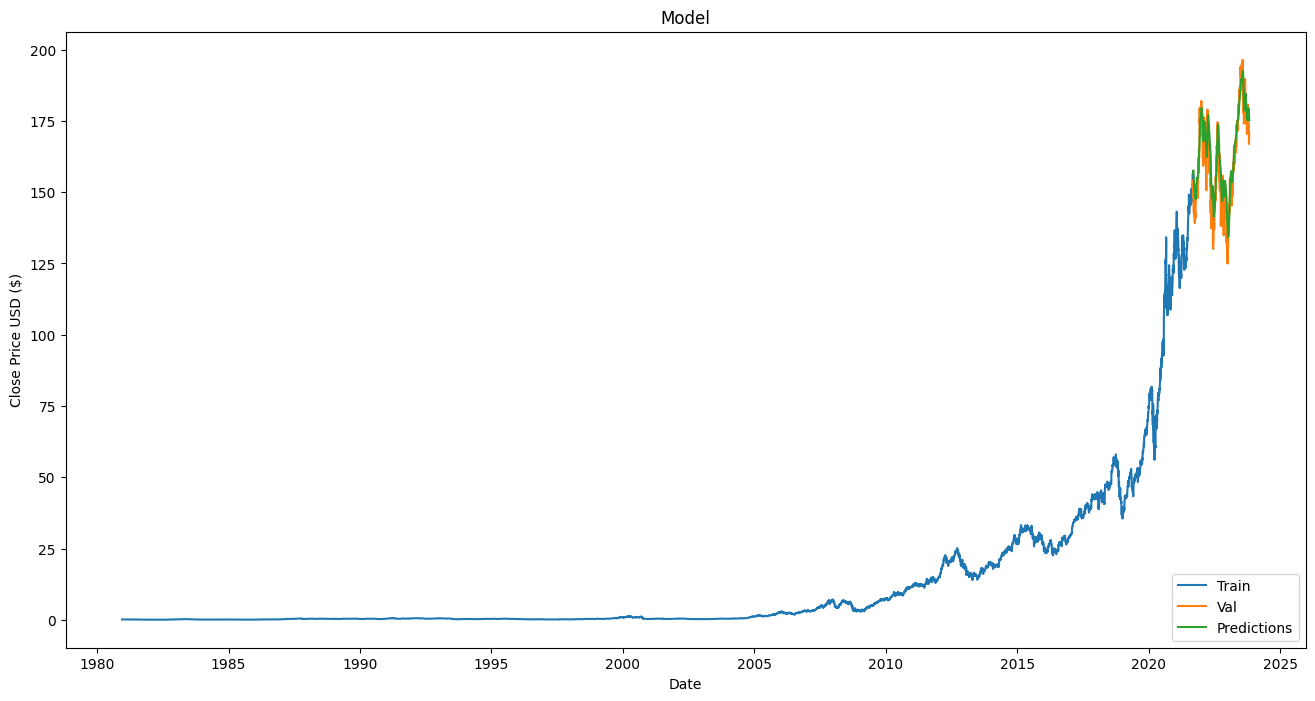

In [8]:
# Plot the data
train = META_data[:train_data_len]
valid = META_data[train_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [9]:
# Predict the stock price for the next day
last_60_days = scaled_data[-60:]
x_pred = []
x_pred.append(last_60_days)
x_pred = np.array(x_pred)
x_pred = np.reshape(x_pred, (x_pred.shape[0], x_pred.shape[1], 1))
pred_price = model.predict(x_pred)
pred_price = scaler.inverse_transform(pred_price)
print("Predicted stock price for tomorrow:", pred_price[0][0])

1/1 [==============================] - 0s 23ms/step
Predicted stock price for tomorrow: 174.53658


In [10]:
# Predict the stock price for the day after tomorrow
last_61_days = np.append(last_60_days[1:], pred_price[0])
x_pred = []
x_pred.append(last_61_days)
x_pred = np.array(x_pred)
x_pred = np.reshape(x_pred, (x_pred.shape[0], x_pred.shape[1], 1))
pred_price = model.predict(x_pred)
pred_price = scaler.inverse_transform(pred_price)
print("Predicted stock price for the day after tomorrow:", pred_price[0][0])

1/1 [==============================] - 0s 22ms/step
Predicted stock price for the day after tomorrow: 215.98395


1/1 [==============================] - 0s 34ms/step


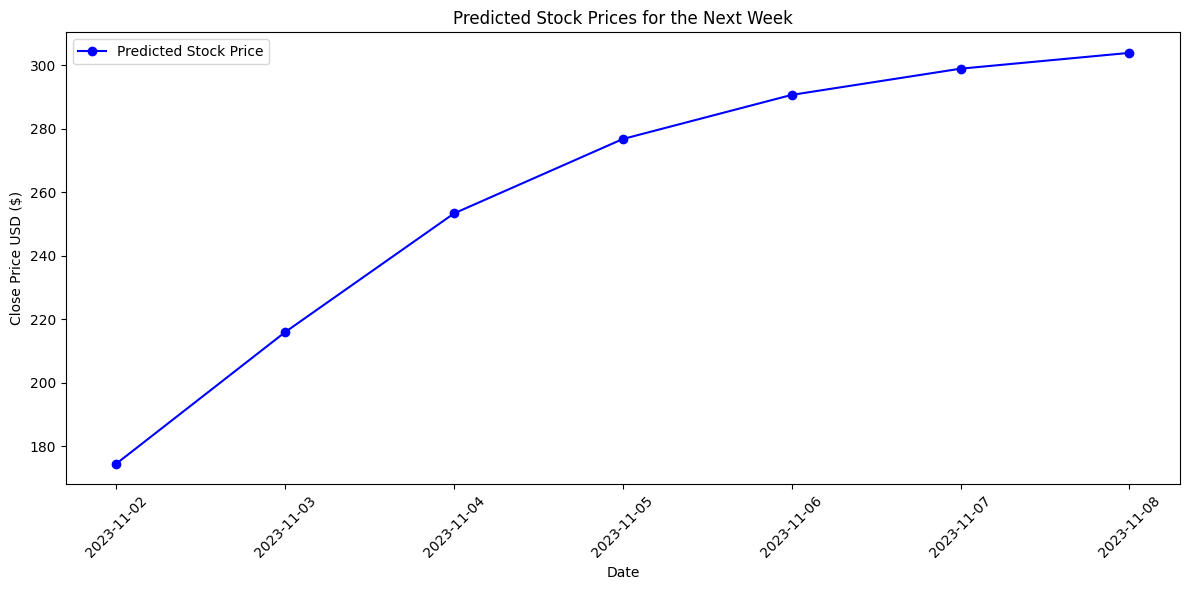

Predicted stock prices for the next week:
            Predicted_Price
2023-11-02       174.536575
2023-11-03       215.983948
2023-11-04       253.353134
2023-11-05       276.790161
2023-11-06       290.684814
2023-11-07       298.938080
2023-11-08       303.919342


In [11]:
# Predict stock prices for the next week
predicted_prices = []
last_60_days = scaled_data[-60:]

for _ in range(7):
    x_pred = []
    x_pred.append(last_60_days)
    x_pred = np.array(x_pred)
    x_pred = np.reshape(x_pred, (x_pred.shape[0], x_pred.shape[1], 1))
    pred_price = model.predict(x_pred)
    pred_price = scaler.inverse_transform(pred_price)
    predicted_prices.append(pred_price[0][0])
    last_60_days = np.append(last_60_days[1:], pred_price)

# Generate dates for the next week
current_date = datetime.datetime.now()
next_week_dates = [current_date + datetime.timedelta(days=i) for i in range(1, 8)]
next_week_dates_str = [date.strftime('%Y-%m-%d') for date in next_week_dates]

# Create a DataFrame for predicted prices
predicted_data = pd.DataFrame(data=predicted_prices, index=next_week_dates_str, columns=['Predicted_Price'])

# Plotting the predicted stock prices for the next week
plt.figure(figsize=(12, 6))
plt.title('Predicted Stock Prices for the Next Week')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(predicted_data.index, predicted_data['Predicted_Price'], marker='o', color='b', label='Predicted Stock Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

print("Predicted stock prices for the next week:")
print(predicted_data)


In [12]:
from keras.layers import GRU

# Build GRU model
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(units=50, return_sequences=True))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(units=50))
gru_model.add(Dropout(0.2))

gru_model.add(Dense(units=1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.summary()

# Train GRU model
gru_model.fit(x_train, y_train, epochs=10, batch_size=32)

# Predict stock prices using GRU model
gru_predictions = gru_model.predict(x_test)
gru_predictions = scaler.inverse_transform(gru_predictions)

# Calculate RMSE for GRU model
gru_rmse = np.sqrt(np.mean(((gru_predictions - y_test) ** 2)))
print("GRU Model Root Mean Squared Error (RMSE):", gru_rmse)

# Calculate the MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((gru_predictions - y_test) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calculate the R-squared (R^2)/ model fitting in data
from sklearn.metrics import r2_score
r_squared = r2_score(y_test, gru_predictions)
print("R-squared (R^2):", r_squared)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            7950      
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

<ipython-input-13-4432704736fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gru_valid['GRU_Predictions'] = gru_predictions


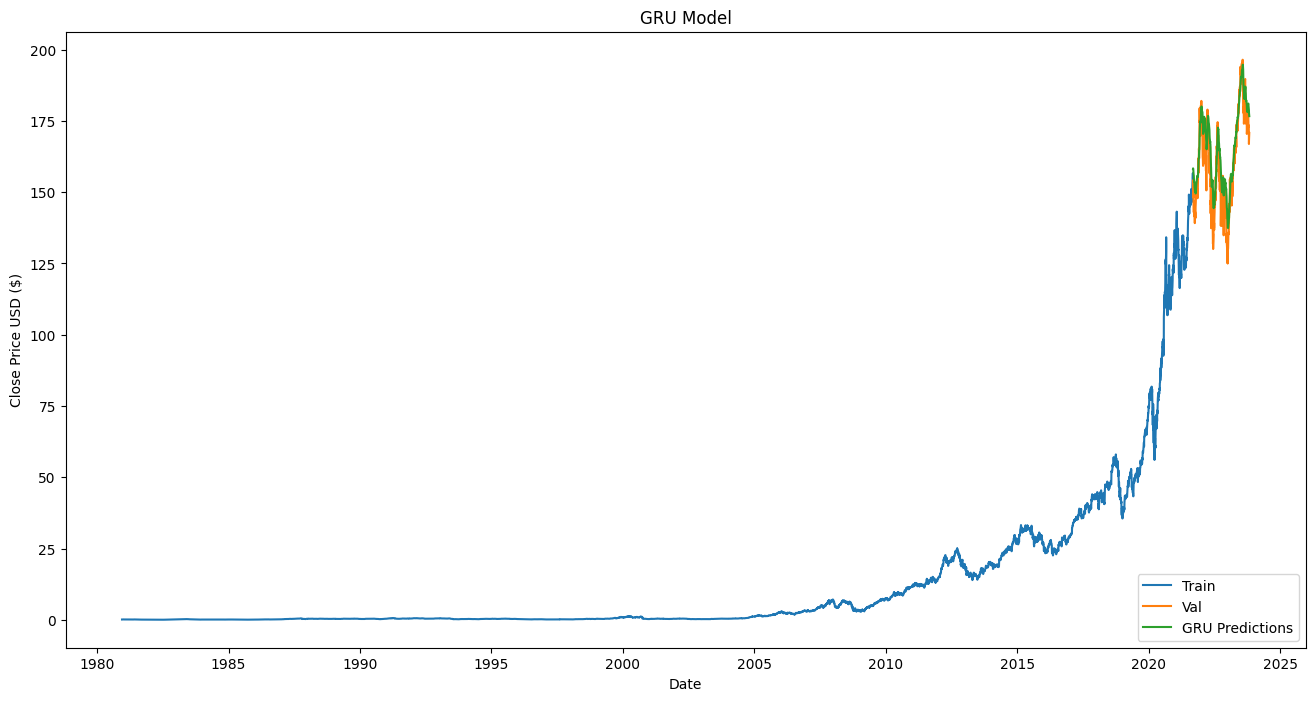

In [13]:
# Plot the data for GRU model
gru_train = META_data[:train_data_len]
gru_valid = META_data[train_data_len:train_data_len+len(gru_predictions)]
gru_valid['GRU_Predictions'] = gru_predictions

plt.figure(figsize=(16,8))
plt.title('GRU Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(gru_train['Close'])
plt.plot(gru_valid[['Close', 'GRU_Predictions']])
plt.legend(['Train', 'Val', 'GRU Predictions'], loc='lower right')
plt.show()

1/1 [==============================] - 0s 27ms/step


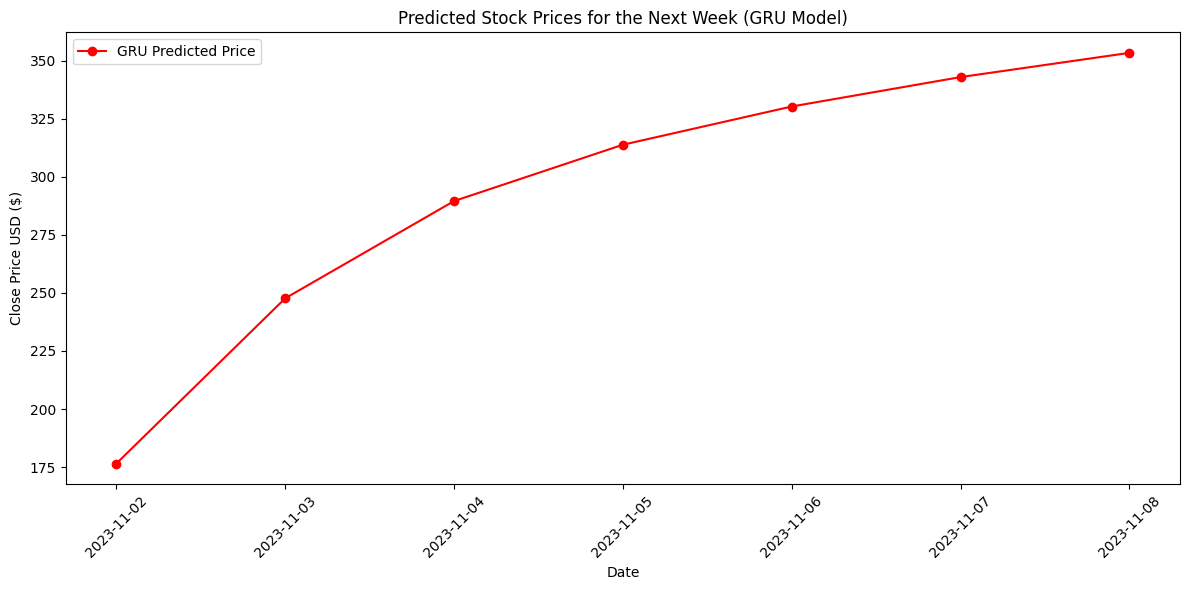

Predicted stock prices for the next week (GRU):
            GRU_Predicted_Price
2023-11-02           176.516953
2023-11-03           247.644653
2023-11-04           289.503326
2023-11-05           313.749207
2023-11-06           330.209869
2023-11-07           342.862427
2023-11-08           353.290314


In [14]:
# Predict stock prices for the next week using GRU model
gru_predicted_prices = []
last_60_days = scaled_data[-60:]

for _ in range(7):
    x_pred = []
    x_pred.append(last_60_days)
    x_pred = np.array(x_pred)
    x_pred = np.reshape(x_pred, (x_pred.shape[0], x_pred.shape[1], 1))
    pred_price = gru_model.predict(x_pred)
    pred_price = scaler.inverse_transform(pred_price)
    gru_predicted_prices.append(pred_price[0][0])
    last_60_days = np.append(last_60_days[1:], pred_price)

# Generate dates for the next week
current_date = datetime.datetime.now()
next_week_dates = [current_date + datetime.timedelta(days=i) for i in range(1, 8)]
next_week_dates_str = [date.strftime('%Y-%m-%d') for date in next_week_dates]

# Create a DataFrame for GRU predicted prices
gru_predicted_data = pd.DataFrame(data=gru_predicted_prices, index=next_week_dates_str, columns=['GRU_Predicted_Price'])

# Plotting the predicted stock prices for the next week (GRU)
plt.figure(figsize=(12, 6))
plt.title('Predicted Stock Prices for the Next Week (GRU Model)')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(gru_predicted_data.index, gru_predicted_data['GRU_Predicted_Price'], marker='o', color='r', label='GRU Predicted Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

print("Predicted stock prices for the next week (GRU):")
print(gru_predicted_data)
